In [ ]:
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import random

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import backend as K
from keras import regularizers, callbacks
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from google.colab.patches import cv2_imshow

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 90, 16)       160       
                                                                 
 average_pooling2d (AverageP  (None, 55, 45, 16)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 55, 45, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 55, 45, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 42, 32)        8224      
                                                                 
 average_pooling2d_1 (Averag  (None, 26, 21, 32)       0

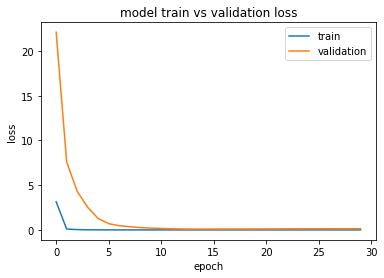

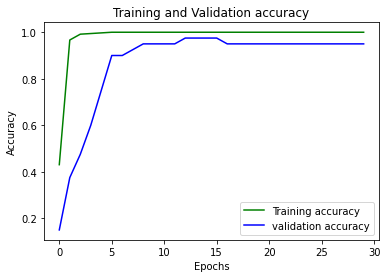

INFO:tensorflow:Assets written to: ram://36c3cbce-c386-45b1-aa90-e414ee2465ff/assets
Test loss: 0.13805755972862244
Test accuracy: 0.949999988079071


AttributeError: ignored

In [ ]:
def train_model():
    path = '/content/drive/MyDrive/Classroom/orl_LTP/'

        # 1-hot encoding
    a = np.array([i for i in range(43)])
    classes = np.zeros((a.size, a.max() + 1))
    classes[np.arange(a.size), a] = 1

    train_array = []
    test_array = []
    dir_array = []

    for dir in os.listdir(path):
        i1 = np.random.choice(range(0,9), 4)
        #i1 = np.random.choice(range(0,9), 5)
        #i1 = np.random.choice(range(0,9), 6)
        for i1, img in enumerate(sorted(os.listdir(path + dir))):
            image = cv2.imread(path + dir + '/' + img, 0)
            image = image[:, :, np.newaxis]
            if i1:
                train_array.append((image, classes[os.listdir(path).index(dir)]))
            elif not(i1):
                test_array.append((image, classes[os.listdir(path).index(dir)]))


        dir_array.append(dir)

    input_shape = (112, 92, 1)

    model = Sequential()
    # convolutional layer 16 windows/filters of 3x3
    model.add(Conv2D(16, kernel_size=(3,3),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.),
                     input_shape=input_shape))

    # max of each 2x2 block
    model.add(AveragePooling2D(pool_size=(2, 2)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # normalization
    model.add(BatchNormalization())

    # avoid overfitting
    model.add(Dropout(0.25))
    #model.add(Dropout(0.50))

    model.add(Conv2D(32, kernel_size=(4,4),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.)))

    model.add(AveragePooling2D(pool_size=(2, 2)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    #model.add(Dropout(0.50))
    
    # flatten for final layers
    model.add(Flatten())

    # fully-connected layer
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.),
                    activity_regularizer=regularizers.l2(0.)))

    model.add(Dropout(0.25))
    #model.add(Dropout(0.50))

    model.add(Dense(43, activation='softmax'))
    #model.add(Dense(43, activation='relu', kernel_regularizer=regularizers.l2(0.), activity_regularizer=regularizers.l2(0.))) # very low accuracy


    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
                  run_eagerly=None)

    train_images, train_labels = np.array([t[0] for t in train_array]), np.array([t[1] for t in train_array])
    test_images, test_labels = np.array([t[0] for t in test_array]), np.array([t[1] for t in test_array])

    history = model.fit(train_images, train_labels,
                        batch_size=16,
                        epochs=30,
                        verbose=2,
                        validation_data=(test_images, test_labels))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    loss_train = history.history['accuracy']
    loss_val = history.history['val_accuracy']
    epochs = range(0,30)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')  
    plt.legend()
    plt.show()

    with open('face_recognition_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    return test_images, test_labels, classes, dir_array
def evaluate_model(test_images, test_labels, classes, dir_array):
    with open('face_recognition_model.pkl', 'rb') as f:
        model = pickle.load(f)

    score = model.evaluate(test_images, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

# evaluate test images added in the orl database
    imageindex = 9

    paths1 = '/content/drive/MyDrive/Classroom/orl_LTP/s1_LTP_' + str(imageindex) + '.pgm'
    s1 = cv2.imread(paths1, cv2.IMREAD_UNCHANGED)
    cv2_imshow(s1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    s1 = cv2.resize(s1, (92, 112))
    s1 = s1[:, :, np.newaxis]

    imageindex = 9

    paths2 = '/content/drive/MyDrive/Classroom/orl_LTP/s2_LTP_' + str(imageindex) + '.pgm'
    s2 = cv2.imread(s2, cv2.IMREAD_UNCHANGED)
    cv2_imshow(s2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    s2 = cv2.resize(s2, (92, 112))
    s2 = s2[:, :, np.newaxis]

    imageindex = 9

    paths3 = '/content/drive/MyDrive/Classroom/orl_LTP/s3_LTP_' + str(imageindex) + '.pgm'
    s3 = cv2.imread(s3, cv2.IMREAD_UNCHANGED)
    cv2_imshow(s3)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    s3 = cv2.resize(s3, (92, 112))
    s3 = s3[:, :, np.newaxis]

    people_test_image = np.array([s1, s2, s3])

    [prediction1, prediction2, prediction3] = model.predict(people_test_image)

    a = max([(c, cosine_similarity([prediction1], [c])) for c in classes], key=lambda t:t[1])
    b = max([(c, cosine_similarity([prediction2], [c])) for c in classes], key=lambda t:t[1])
    c = max([(c, cosine_similarity([prediction3], [c])) for c in classes], key=lambda t:t[1])

    print(dir_array[list(a[0]).index(1)])
    print(dir_array[list(b[0]).index(1)])
    print(dir_array[list(c[0]).index(1)])

ti, tl, c, d = train_model()
evaluate_model(ti, tl, c, d)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')